In [1]:
import numpy as np
import pandas as pd
from math import sin, cos, sqrt, atan2, radians
import datetime
from matplotlib import pyplot as plt
import seaborn as sns

### Dataset source: https://www.kaggle.com/datasets/kartik2112/fraud-detection

In [2]:
#Load file
file=pd.read_csv('fraudTrain.csv')

In [3]:
# delete unnamed column
df = file.loc[:, ~file.columns.str.contains('^Unnamed')]

In [4]:
df.head(5)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [5]:
#convert latitude and longitude radians for measuring distance
df['radian_lat'] = df.apply(lambda row: radians(row.lat), axis = 1)


In [6]:
#convert latitude and longitude radians for measuring distance

df['radian_long'] = df.apply(lambda row: radians(row.long), axis = 1)
df['radian_mlat'] = df.apply(lambda row: radians(row.merch_lat), axis = 1)
df['radian_mlong'] = df.apply(lambda row: radians(row.merch_long), axis = 1)


In [7]:
df.head(5)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,radian_lat,radian_long,radian_mlat,radian_mlong
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,0.629694,-1.416825,0.628516,-1.432013
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,0.853253,-2.063162,0.857987,-2.062743
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,0.736194,-1.959342,0.753122,-1.957465
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,0.806876,-1.956755,0.820904,-1.964561
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,0.670568,-1.386889,0.675006,-1.372395


In [8]:
# Function to Get distance between two points 

# approximate radius of earth in km
def dist(lat1,lon1,lat2,lon2):
    R=6373.0
    dlon=lon2-lon1
    dlat=lat2-lat1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))

    return R * c

In [9]:
# Add new column with distance between owner and merchant
df['ownerToMerdist']= dist(df['radian_lat'],df['radian_long'],df['radian_mlat'],df['radian_mlong'])


In [10]:
df.head(5)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,trans_num,unix_time,merch_lat,merch_long,is_fraud,radian_lat,radian_long,radian_mlat,radian_mlong,ownerToMerdist
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,0.629694,-1.416825,0.628516,-1.432013,78.622242
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,0.853253,-2.063162,0.857987,-2.062743,30.221660
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,0.736194,-1.959342,0.753122,-1.957465,108.240051
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,0.806876,-1.956755,0.820904,-1.964561,95.703265
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,0.670568,-1.386889,0.675006,-1.372395,77.581090


In [11]:
#add date_time column by converting trans_date_trans_time to date time 
df['date_time']=pd.to_datetime(df['trans_date_trans_time'])

In [12]:
# strip out date and time and add as new column
df['date']=df['date_time'].dt.date
df['time']=df['date_time'].dt.time

In [13]:
# strip out hour and add as new column

df['time_hour']=df['date_time'].dt.hour

In [14]:
df.tail(5)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,is_fraud,radian_lat,radian_long,radian_mlat,radian_mlong,ownerToMerdist,date_time,date,time,time_hour
1296670,2020-06-21 12:12:08,30263540414123,fraud_Reichel Inc,entertainment,15.56,Erik,Patterson,M,162 Jessica Row Apt. 072,Hatch,...,0,0.658295,-1.963106,0.643001,-1.949372,119.789729,2020-06-21 12:12:08,2020-06-21,12:12:08,12
1296671,2020-06-21 12:12:19,6011149206456997,fraud_Abernathy and Sons,food_dining,51.70,Jeffrey,White,M,8617 Holmes Terrace Suite 651,Tuscarora,...,0,0.685333,-1.352806,0.679053,-1.365660,75.127662,2020-06-21 12:12:19,2020-06-21,12:12:19,12
1296672,2020-06-21 12:12:32,3514865930894695,fraud_Stiedemann Ltd,food_dining,105.93,Christopher,Castaneda,M,1632 Cohen Drive Suite 639,High Rolls Mountain Park,...,0,0.574904,-1.846888,0.586771,-1.834874,99.078827,2020-06-21 12:12:32,2020-06-21,12:12:32,12
1296673,2020-06-21 12:13:36,2720012583106919,"fraud_Reinger, Weissnat and Strosin",food_dining,74.90,Joseph,Murray,M,42933 Ryan Underpass,Manderson,...,0,0.756646,-1.789680,0.746808,-1.801898,84.654219,2020-06-21 12:13:36,2020-06-21,12:13:36,12
1296674,2020-06-21 12:13:37,4292902571056973207,"fraud_Langosh, Wintheiser and Hyatt",food_dining,4.30,Jeffrey,Smith,M,135 Joseph Mountains,Sula,...,0,0.800117,-1.987490,0.812730,-1.992924,83.879979,2020-06-21 12:13:37,2020-06-21,12:13:37,12


In [15]:
df.head(1).T

,0
trans_date_trans_time,2019-01-01 00:00:18
cc_num,2703186189652095
merchant,"fraud_Rippin, Kub and Mann"
category,misc_net
amt,4.97
first,Jennifer
last,Banks
gender,F
street,561 Perry Cove
city,Moravian Falls


In [16]:
# set today to last date of dateset (Dec 31 2020
today = datetime.datetime(2020, 12, 31)

In [17]:
today

datetime.datetime(2020, 12, 31, 0, 0)

In [18]:
# convert date of birth to date_time format
df['dob'] =pd.to_datetime(df['dob'], format='%Y/%m/%d')

In [19]:
# set now to last date of dateset (Dec 31 2020)

now = pd.Timestamp('12-31-2020')

In [20]:
# calculate age as of last date of dataset i.e "today"
df['dob'] = df['dob'].where(df['dob'] < now, df['dob'] -  np.timedelta64(100, 'Y'))   
df['age'] = (now - df['dob']).astype('<m8[Y]')    

In [21]:
df.head(2)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,radian_lat,radian_long,radian_mlat,radian_mlong,ownerToMerdist,date_time,date,time,time_hour,age
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,0.629694,-1.416825,0.628516,-1.432013,78.622242,2019-01-01 00:00:18,2019-01-01,00:00:18,0,32.0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,0.853253,-2.063162,0.857987,-2.062743,30.221660,2019-01-01 00:00:44,2019-01-01,00:00:44,0,42.0


In [22]:
fraud_df=df[df['is_fraud']==1]

<AxesSubplot:xlabel='age', ylabel='Count'>

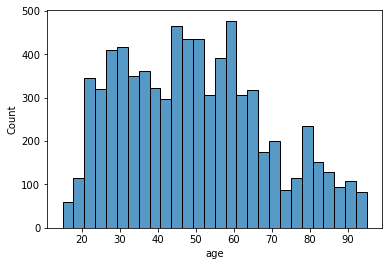

In [23]:
sns.histplot(data=fraud_df, x="age")


<AxesSubplot:xlabel='time_hour', ylabel='Count'>

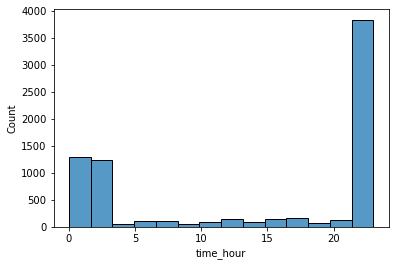

In [24]:
sns.histplot(data=fraud_df, x="time_hour")


In [25]:
fraud_df.groupby('time_hour').size()


time_hour
0      635
1      658
2      625
3      609
4       46
5       60
6       40
7       56
8       49
9       47
10      40
11      42
12      67
13      80
14      86
15      79
16      76
17      78
18      81
19      81
20      62
21      74
22    1931
23    1904
dtype: int64

<AxesSubplot:xlabel='ownerToMerdist', ylabel='Count'>

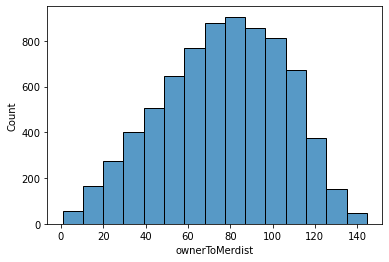

In [26]:
sns.histplot(data=fraud_df, x="ownerToMerdist", bins=15)


In [30]:
df.dtypes

trans_date_trans_time            object
cc_num                            int64
merchant                         object
category                         object
amt                             float64
first                            object
last                             object
gender                           object
street                           object
city                             object
state                            object
zip                               int64
lat                             float64
long                            float64
city_pop                          int64
job                              object
dob                      datetime64[ns]
trans_num                        object
unix_time                         int64
merch_lat                       float64
merch_long                      float64
is_fraud                          int64
radian_lat                      float64
radian_long                     float64
radian_mlat                     float64


In [31]:
# convert gender and is_fraud to category
df['is_fraud']=df['is_fraud'].astype("category")
df['gender']=df['gender'].astype("category")

In [82]:
#Table with fraud victim breakdown by Gender
df_plot_gender = df.groupby(['gender', 'is_fraud']).size()
df_plot_gender = df_plot_gender.reset_index()
df_plot_gender = df_plot_gender.rename({0:'count'}, axis=1)

df_plot_gender

,gender,is_fraud,count
0,F,0,706128
1,F,1,3735
2,M,0,583041
3,M,1,3771


In [83]:
#add percentage given that different sample size
male_female=df.groupby(['gender']).size().reset_index().rename({0:'total_gender'}, axis=1)
df_plot_gender=df_plot_gender.merge(male_female,on='gender')
df_plot_gender['percentage']=(df_plot_gender['count']/df_plot_gender['total_gender'])*(100)
df_plot_gender['percentage']=df_plot_gender['percentage'].round(2)

In [84]:
df_plot_gender

,gender,is_fraud,count,total_gender,percentage
0,F,0,706128,709863,99.47
1,F,1,3735,709863,0.53
2,M,0,583041,586812,99.36
3,M,1,3771,586812,0.64


Text(0.5, 0.98, 'Amount of fraud and non-fraud transactions by Gender')

<Figure size 1080x432 with 0 Axes>

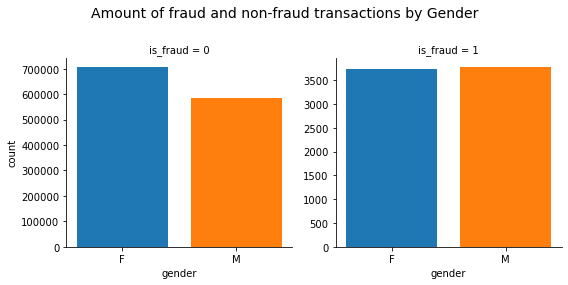

In [144]:
#Plot Count of Fraudulant and non-Fraudulant Transactions by Gender
plt.figure(figsize=(15, 6))
g = sns.FacetGrid(df_plot_gender, col = 'is_fraud', hue = 'gender',sharey=False,height=4, aspect=1)
g.map(plt.bar, 'gender', 'count')
g.fig.subplots_adjust(top=.8)
g.fig.suptitle('Amount of fraud and non-fraud transactions by Gender', fontsize=14)

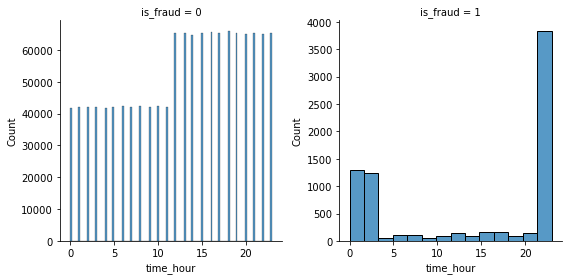

In [161]:
g = sns.FacetGrid(df, col="is_fraud",sharey=False,height=4, aspect=1)
g.map_dataframe(sns.histplot, x="time_hour")

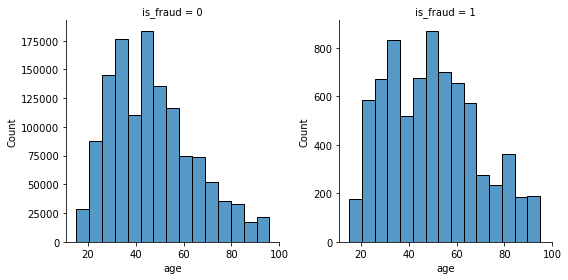

In [163]:
g = sns.FacetGrid(df, col="is_fraud",sharey=False,height=4, aspect=1)
g.map_dataframe(sns.histplot, x="age",bins=15)

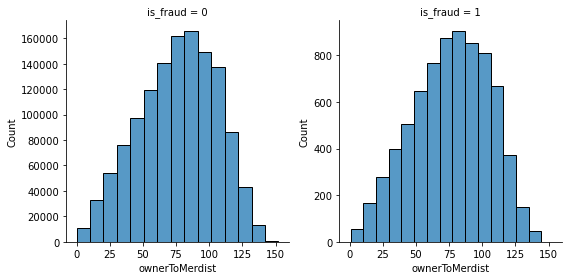

In [164]:
g = sns.FacetGrid(df, col="is_fraud",sharey=False,height=4, aspect=1)
g.map_dataframe(sns.histplot, x="ownerToMerdist",bins=15)

In [133]:
df_dist = pd.melt(df, id_vars = ['is_fraud'], 
                    value_vars = ['time_hour'])
df_dist

,is_fraud,variable,value
0,0,time_hour,0
1,0,time_hour,0
2,0,time_hour,0
3,0,time_hour,0
4,0,time_hour,0
...,...,...,...
1296670,0,time_hour,12
1296671,0,time_hour,12
1296672,0,time_hour,12
1296673,0,time_hour,12


<AxesSubplot:xlabel='is_fraud', ylabel='value'>

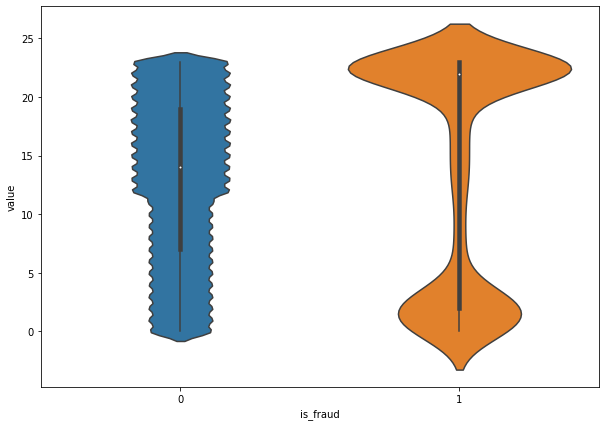

In [168]:
plt.figure(figsize=(10,7))

sns.violinplot(x = 'is_fraud', y = 'value', data = df_dist)
